## Table of Contents

- Importing Libraries
- Importing Dataframes
- Exploring Dataframes
- Subsetting and Wrangling Time Series Data
- Time-Series Analysis: Decomposition
- Testing for Stationarity
- Stationarizing the Dataframe

## Importing Libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

## Importing Dataframes

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'mMqJ3pEGg2zimGVgnCZH'

In [3]:
# Importing the US Federal Reserve Economic Data  variable.

data = quandl.get('FED/SUBLPDMHS_XWB_N_Q')

## Exploring Dataframes

In [4]:
data.head(5)

,Value
Date,
2018-03-31,10.0
2018-06-30,5.3
2018-09-30,-13.3
2018-12-31,-12.0
2019-03-31,-1.7


In [5]:
data.shape

(23, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [7]:
type(data)

pandas.core.frame.DataFrame

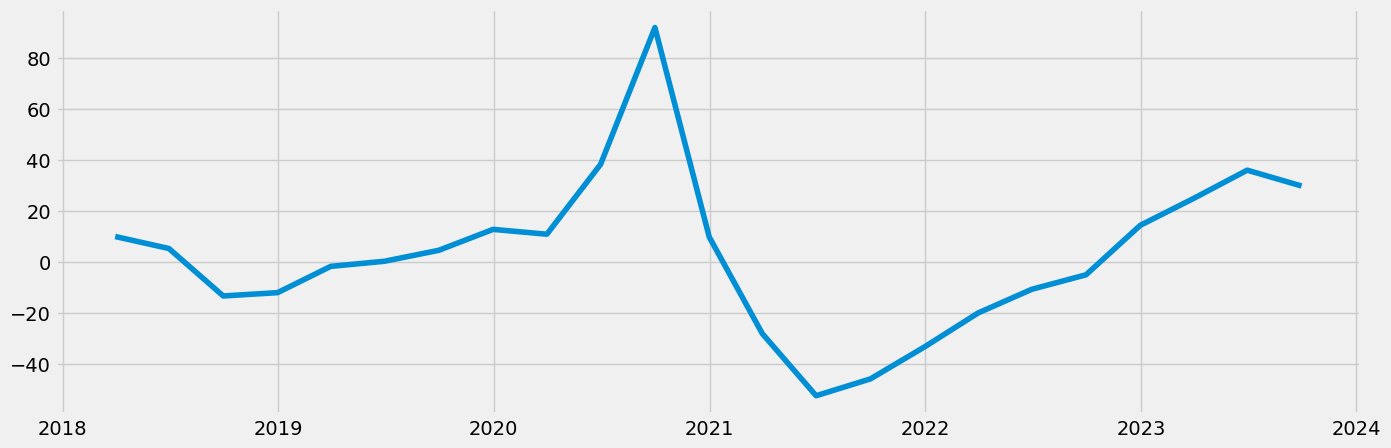

In [8]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

## Subsetting and Wrangling Time Series Data

In [9]:
# Reset index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [10]:
data_2.head()

,Date,Value
0,2018-03-31,10.0
1,2018-06-30,5.3
2,2018-09-30,-13.3
3,2018-12-31,-12.0
4,2019-03-31,-1.7


In [11]:
data_sub = data_2.loc[(data_2['Date'] >= '2018-01-01') & (data_2['Date'] < '2023-09-30')]

In [12]:
data_sub.shape

(22, 2)

In [13]:
data_sub.head()

,Date,Value
0,2018-03-31,10.0
1,2018-06-30,5.3
2,2018-09-30,-13.3
3,2018-12-31,-12.0
4,2019-03-31,-1.7


In [14]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2018-03-31,10.0
2018-06-30,5.3
2018-09-30,-13.3
2018-12-31,-12.0
2019-03-31,-1.7


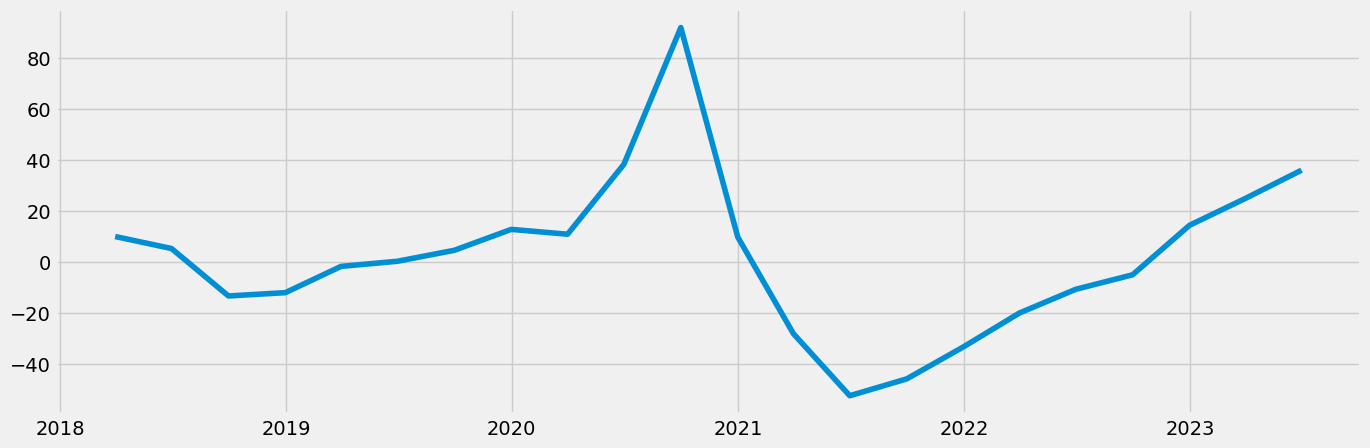

In [15]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [16]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [17]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()



0

## Time-Series Analysis: Decomposition

In [18]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

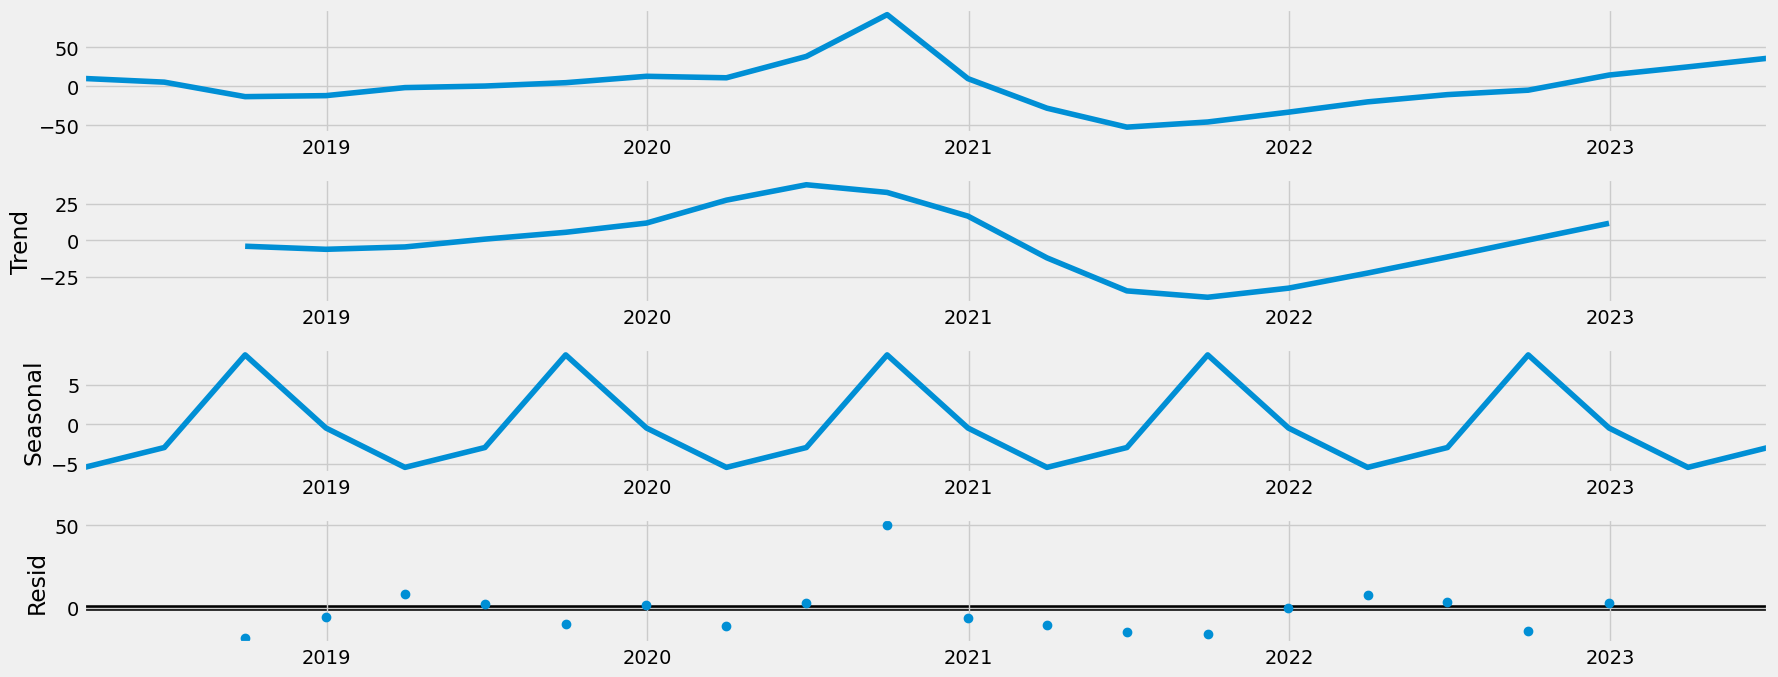

In [20]:
# Plot the separate components

decomposition.plot()
plt.show()

The level and trend look similar (generally similar peaks and line curves) so this suggests that the data is smoothed and does not contain a lot of noise. There is also seasonality which is confirmed by the absence of a flat line in the third line chart. The presence of trend and seasonality implies that this is a non-stationary time series.

## Testing for Stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.448357
p-value                         0.128550
Number of Lags Used             1.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


Test statistic is greater than critical value at 5% and 10%. This means we can't reject null hypothesis. 

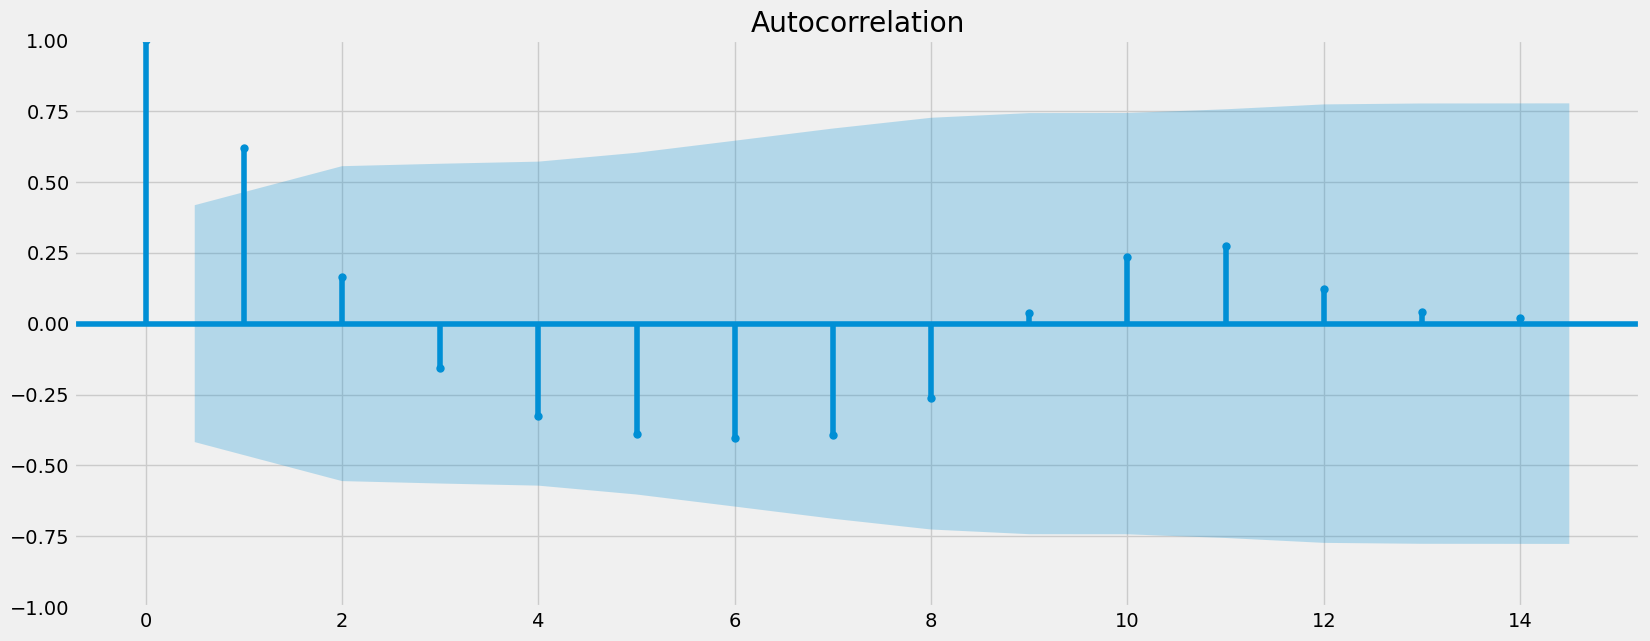

In [22]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The autocorrelation plot seems to suggest that there is stationarity but since the dataset only has 22 rows, we cannot take this at face value. I will stationarize it further to see if the test statistic and critical value change.

## Stationarizing the Dataframe

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

In [25]:
data_diff.head()

,Value
datetime,
2018-06-30,-4.7
2018-09-30,-18.6
2018-12-31,1.3
2019-03-31,10.3
2019-06-30,2.0


In [26]:
data_diff.shape

(21, 1)

In [27]:
data_diff.columns

Index(['Value'], dtype='object')

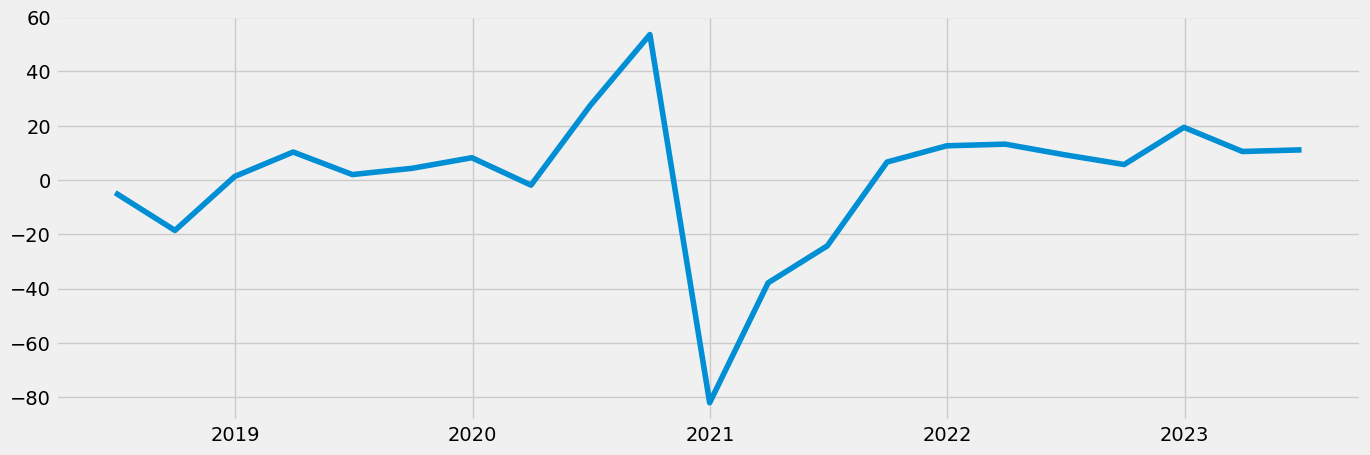

In [28]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

The overall trend still looks similar to the previous plot.

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.704153
p-value                         0.004055
Number of Lags Used             0.000000
Number of Observations Used    20.000000
Critical Value (1%)            -3.809209
Critical Value (5%)            -3.021645
Critical Value (10%)           -2.650713
dtype: float64


Now the test statistic is smaller than the critical value at 5% and 10% so we can say that the time series is now stationary and can be used to forecast.

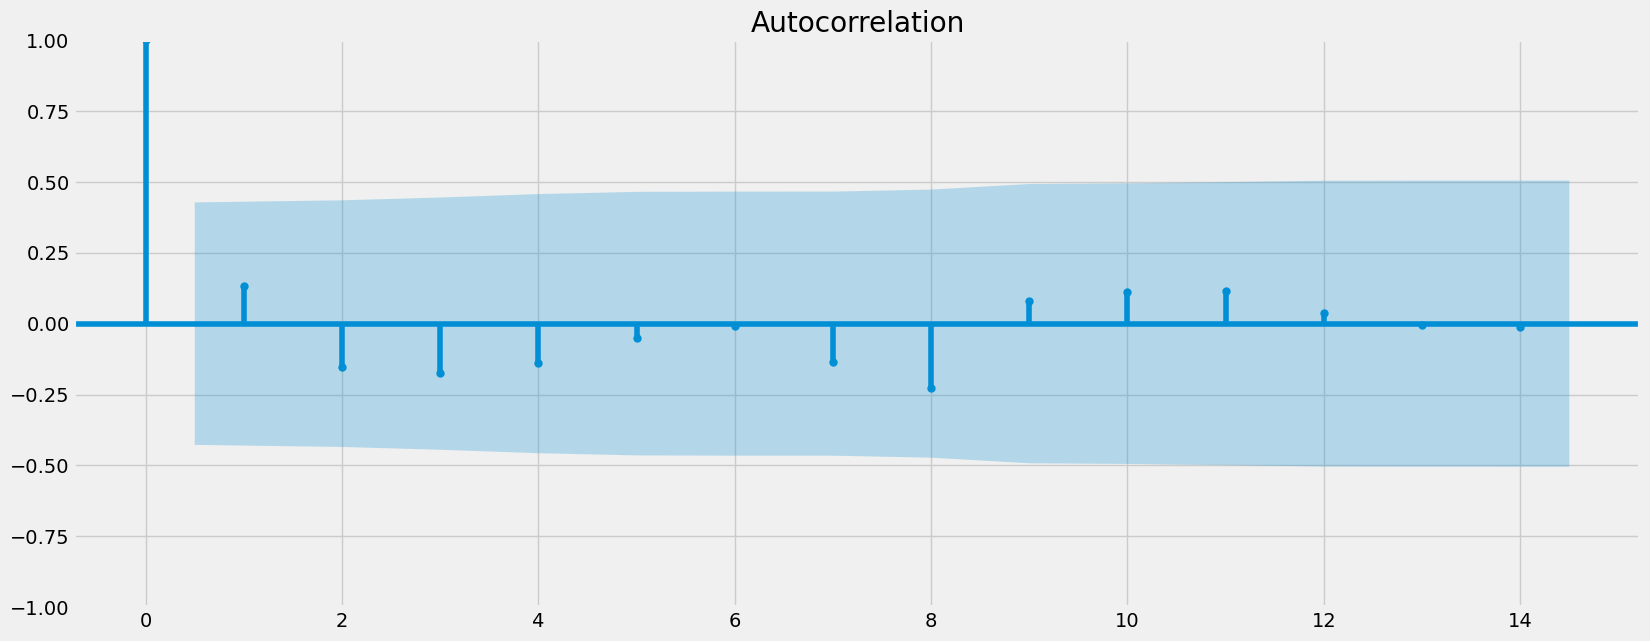

In [30]:
# To confirm further
plot_acf(data_diff)
plt.show()

There are no points above the shaded area. This further confirms the stationarity of the time series.